<a href="https://colab.research.google.com/github/tcaba2/Comp-Astro2024/blob/main/Tutorial%20PCA/Tutorial_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import recall_score, classification_report, precision_score, confusion_matrix, auc, accuracy_score, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.neighbors import KNeighborsClassifier
from scipy import ndimage
import seaborn as sns

In [2]:
#Loading data
test_data = pd.read_csv('exoTest.csv').fillna(0)
train_data = pd.read_csv('exoTrain.csv').fillna(0)

In [3]:
#Encoding labels
categ = {2: 1,1: 0}
train_data.LABEL = [categ[item] for item in train_data.LABEL]
test_data.LABEL = [categ[item] for item in test_data.LABEL]

#Reduce memory
def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

test_data = reduce_memory(test_data)
train_data = reduce_memory(train_data)

Memory usage of dataframe is 13.91 MB
Memory usage after optimization is: 6.25 MB
Decreased by 55.1%
Memory usage of dataframe is 124.12 MB
Memory usage after optimization is: 62.04 MB
Decreased by 50.0%


In [4]:
#splitting the data
x_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]
x_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

#Normalizing the data
x_train = normalized = normalize(x_train)
x_test = normalize(x_test)

In [5]:
# Applying of gaussian filter
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)

# Feature scaling -- after applying Gaussian filters,
# make the Gaussian data have mean of 0 and variance of 1
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)

In [6]:
# Dimensionality reduction
pca = PCA()
X_train_PCA = pca.fit_transform(x_train)
X_test_PCA = pca.transform(x_test)
total_PCA=sum(pca.explained_variance_)
k=0
current_variance_PCA=0
while current_variance_PCA/total_PCA < 0.95:
    current_variance_PCA += pca.explained_variance_[k]
    k=k+1
print("number of components for PCA: ", k)

number of components for PCA:  53


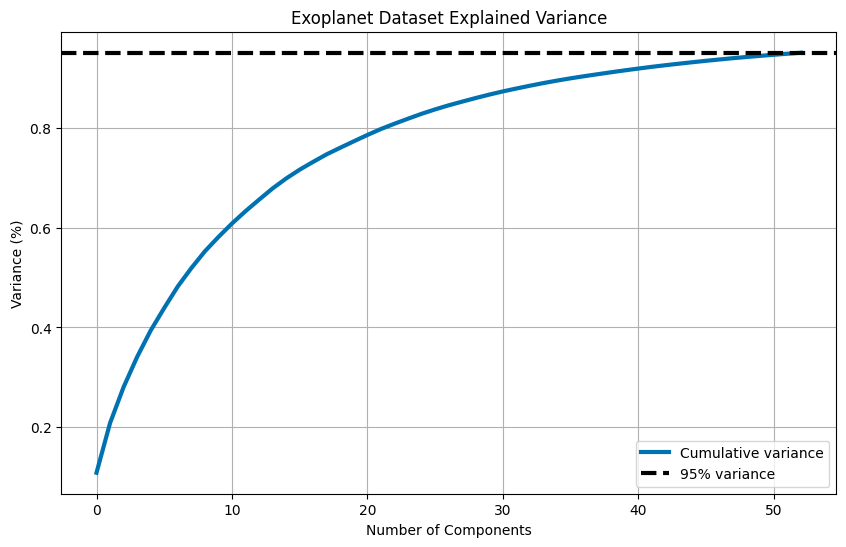

In [7]:
# Apply PCA with n_componenets
pca = PCA(n_components=53)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw=3, label=r'Cumulative variance')
plt.axhline(y=0.95, ls='--', c='k', lw=3, label=r'95% variance')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Exoplanet Dataset Explained Variance')
plt.legend(loc='best')
plt.grid()
plt.show()

In [8]:
#Resampling as the data is highly unbalanced.
from imblearn.combine import SMOTEENN
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTEENN(random_state=42, sampling_strategy = 1.0, n_jobs=-1)
x_train_res, y_train_res = sm.fit_resample(x_train_pca, y_train.ravel())

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 37
Before OverSampling, counts of label '0': 5050 

After OverSampling, counts of label '1': 5050
After OverSampling, counts of label '0': 5049


Validation accuracy of KNN is 0.9912280701754386

Classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

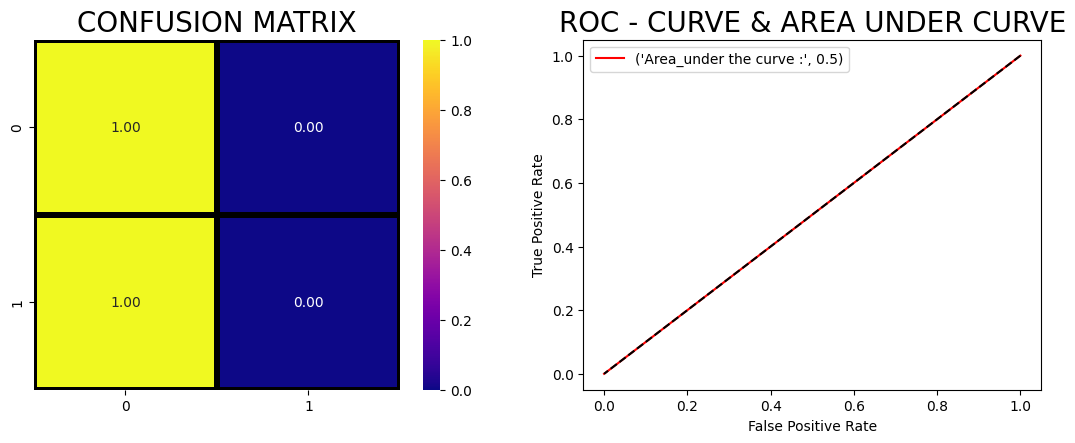

In [9]:
#K-NN for PCA
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()

knn_model.fit(x_train_res,y_train_res)
prediction=knn_model.predict(x_test_pca)
print('Validation accuracy of KNN is', accuracy_score(prediction,y_test))
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction, normalize='true'),annot=True,cmap="plasma",fmt = ".2f",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = knn_model.predict_proba(x_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)